In [1]:
!pip install arch

In [2]:
import os
import datetime as dt
import numpy as np
import random
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from arch import arch_model
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow_probability as tfp

quantile = 0.5
random.seed(1)

Using TensorFlow backend.


In [0]:
def GARCH(y, start, end, split_date):
    """ General Autoregressive Conditional Heteroskedasticity Model 
    p -> Lag length
    q -> Order of ARCH terms
    y -> Timeseries Dataframe
    """
    model = arch_model(y, vol='Garch', p=1, o=0, q=1, dist='StudentsT')
    results = model.fit(last_obs=split_date)
    print(results.summary())

    sims = results.forecast(horizon=8, start=split_date)

    sims.variance[split_date:].plot()
    plt.title("Variance Forecast from " + split_date.strftime("%m/%d/%Y") +
              " to " + end.strftime("%m/%d/%Y") + " (m/d/y)")
    plt.ylabel("Variance [%]")
    plt.show()

In [0]:
def htqf_fun(p):
    """Uses tensorflow functions to calculate the value at the quantile specified by the global variable 'quantile'

    Arguments:
        p {tensor} -- tensor that holds the mean, standard deviation, u-value (left tail weight), and v-value (right tail weight)

    Returns:
        tensor -- value at quantile
    """
    global quantile
    return p[0] + tf.abs(p[1])*tfp.distributions.Normal(loc=p[0], scale=tf.abs(p[1])).quantile(quantile) *\
        (tf.math.exp(p[2] * tfp.distributions.Normal(loc=p[0], scale=tf.abs(p[1])).quantile(quantile)) / 4 + 1) *\
        (tf.math.exp(-p[3] * tfp.distributions.Normal(loc=p[0],
                                                      scale=tf.abs(p[1])).quantile(quantile))/4 + 1)

In [0]:
def pinball_loss(y_true, y_pred):
    """Custom loss function for quantile regression
        - Ideally the quantiles would change and it would optimize
            over all instead of just at one quantile.

    Arguments:
        y_true {tensor} -- True value
        y_pred {tensor} -- Predicted parameters for the HTQF

    Returns:
        tensor -- loss
    """
    quant = tf.map_fn(fn=htqf_fun, elems=y_pred, dtype=tf.float32)
    err = y_true - quant
    return K.maximum(0.5 * err, (0.5 - 1) * err)

In [0]:
def moment(x, mu, order):
    """ Returns the moment sepecified by the order
    x       -> value
    mu      -> mean
    order   -> what moment to return

    Example:
        moment(x, mu, 2) -> second moment
        moment(x, mu, 3) -> third moment
    """
    if order == 1:
        return x

    return (x-mu)**order


In [0]:
def calculate_feature_vector(r_t, L):
    """ Calculates the feature vector for the LSTM Machine
    r_t -> returns
    L -> Lookback length
    """
    mu = sum(r_t[-L-1:-1]) / L

    return np.array([moment(r_t[-L], mu, 1),
                     moment(r_t[-L], mu, 2),
                     moment(r_t[-L], mu, 3),
                     moment(r_t[-L], mu, 4)])

In [0]:
def partition_data(ts, L, p_train, p_test, p_val):
    """Partition the data for training, testing, and validation

    Arguments:
        ts {np.array} -- Timeseries
        L {int} -- Lookback length
        p_train {float} -- Percentage of data to make training
        p_test {float} -- percentage of data to make testing
        p_val {float} -- percentage of data to make validation

    Returns:
        [type] -- [description]
    """
    x = []
    y = []

    for i in range(L+1, len(ts)):
        x.append(calculate_feature_vector(ts[i-L-1:i], L))
        y.append(ts[i])

    x = np.array(x)
    y = np.array(y)

    x_train = x[0:int(len(x)*p_train)]
    y_train = y[0:int(len(y)*p_train)]

    x_val = x[len(x_train):len(x_train) + int(len(x)*p_val)]
    y_val = y[len(x_train):len(x_train) + int(len(x)*p_val)]

    x_test = x[len(x_train) + len(x_val):
               len(x_train)+len(x_val)+int(len(x)*p_test)]

    y_test = y[len(x_train) + len(x_val):len(x_train) +
               len(x_val)+int(len(x)*p_test)]

    return  np.expand_dims(x_train, axis=1),\
            y_train,\
            np.expand_dims(x_test, axis=1),\
            y_test,\
            np.expand_dims(x_val, axis=1),\
            y_val

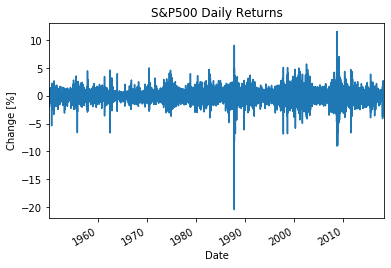

In [9]:
start = dt.datetime(1950, 1, 4)
end = dt.datetime(2018, 6, 1)
data = web.get_data_yahoo('^GSPC', start=start, end=end)
r_t = 100*data['Close'].pct_change().dropna()
plt.title("S&P500 Daily Returns")
plt.ylabel("Change [%]")
r_t.plot()
plt.show()

/root/.local/lib/python3.6/site-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 17644.170571314113
Iteration:      2,   Func. Count:     20,   Neg. LLF: 17633.518859727705
Iteration:      3,   Func. Count:     28,   Neg. LLF: 17623.374491287337
Iteration:      4,   Func. Count:     38,   Neg. LLF: 17622.26381268903
Iteration:      5,   Func. Count:     46,   Neg. LLF: 17591.619337183336
Iteration:      6,   Func. Count:     54,   Neg. LLF: 17588.811288114695
Iteration:      7,   Func. Count:     62,   Neg. LLF: 17585.526074131772
Iteration:      8,   Func. Count:     71,   Neg. LLF: 17584.877684522842
Iteration:      9,   Func. Count:     79,   Neg. LLF: 17582.374123877195
Iteration:     10,   Func. Count:     87,   Neg. LLF: 17581.89482668523
Iteration:     11,   Func. Count:     95,   Neg. LLF: 17581.590471782296
Iteration:     12,   Func. Count:    103,   Neg. LLF: 17581.405684942292
Iteration:     13,   Func. Count:    110,   Neg. LLF: 17581.40018774135
Iteration:     14,   Func. Count:    117,   Neg. LLF: 

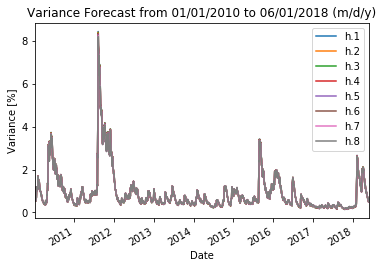

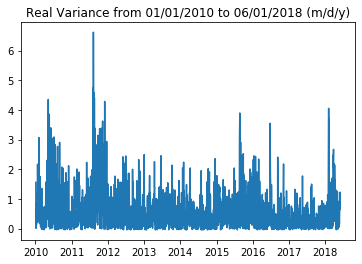

In [10]:
split_date = dt.datetime(2010, 1, 1)
GARCH(r_t, start, end, split_date)

# Plotting the acutal variances (assuming mean = 0)
actual_variance = r_t[split_date:]
actual_variance.values[:] = np.abs(actual_variance.values[:]) - actual_variance.mean()
plt.plot(actual_variance)
plt.title("Real Variance from " + split_date.strftime("%m/%d/%Y") + " to " + end.strftime("%m/%d/%Y") + " (m/d/y)")
plt.show()

In [0]:
L_set = [40, 60, 80, 100]
H_set = [8, 16]
L = L_set[3]
H = H_set[1]
K_quantiles = 21
quantiles = [i / (K_quantiles+1) for i in range(1, K_quantiles+1)]
x_train, y_train, x_test, y_test, x_val, y_val = partition_data(r_t, L, 0.8, 0.1, 0.1)

In [12]:
model = Sequential()
model.add(LSTM(H, input_shape=(1, 4)))
model.add(Dense(4, activation='relu'))
print(model.summary())

model.compile(loss=pinball_loss, optimizer='adam')




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1344      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________
None

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
model.fit(x_train, y_train, batch_size=1, validation_data=(x_val, y_val))




Train on 13689 samples, validate on 1711 samples
Epoch 1/1





13689/13689 [==============================] - 128s 9ms/step - loss: 0.3138 - val_loss: 0.4405


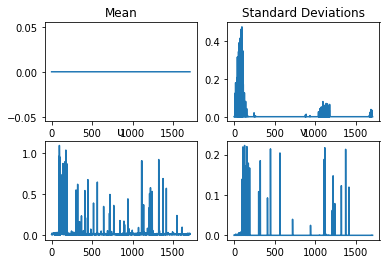

In [14]:
h_t = model.predict(x_test)

fig, axs = plt.subplots(2, 2)

axs[0][0].plot(np.abs(h_t.T[0]))
axs[0][0].set_title("Mean")

axs[0][1].plot(np.abs(h_t.T[1]))
axs[0][1].set_title("Standard Deviations")

axs[1][0].plot(np.abs(h_t.T[2]))
axs[1][0].set_title("u")

axs[1][1].plot(np.abs(h_t.T[3]))
axs[1][1].set_title("v")

plt.show()